# Assignment 3: Reinforcement Learning Coding Problem

In this part of the assignment you'll learn to implement the popular reinforcement learning algorithm Q-Learning.
Let's first start by installing and importing some useful packages.


## Set Up 

The following packages are installed by default in Google Colab, but just in case let's install them anyway.
We'll use `numpy` for scientific computing and `matplotlib` for generating plots and animations.

In [ ]:
!pip install numpy
!pip install matplotlib

Once installed, all there's left to do is import each package.
You're not allowed to use any other packages other than the ones imported below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation    # for making fancy animations
from matplotlib import colors               # for pretty colors
from matplotlib import rc            
rc('animation', html='jshtml')              # set up animation format

## Gridworlds

For this assignment, we'll be training agents in abstract environments called gridworlds.
In this type of environments the agent is tasked with navigating a grid until they reach a terminal state.

We'll use a generic `GridEnvironment` class that will allow us to define a gridworld as a `numpy` array. 
The main method the agents will be using to interact with the environment is the  `step` method, which takes an action and returns the next state, reward, and termination signal.

In [ ]:
class GridEnvironment:

    def __init__(self, grid: np.ndarray, start: np.ndarray, rps=-1, tpr=1, 
                 tnr=-99):
        """
        param grid:     (2D numpy array of type np.int64) each elemnt in the 
                        array should be 0, 1, or -1, where:
                            • 0 represents a walkable square; the agent can
                              move in an out of this kind of squares
                            • 1 represents a a terminal state that results in
                              positive reward. When an agent enters this state
                              the episode concludes and the agent gets a 
                              positive reward
                            • -1 represents a terminal state that results in 
                              negative reward
        param start:    (2D numpy array of type np.int64) the array corresponds
                        to the (x,y) coordinates of the initial state of the 
                        environment
        param rps:      (int or float) reward per step
        param tpr:      (int or float) terminal positive reward. Reward awarded
                        for reaching a terminal state that has positive reward
        param tnr:      (int or float) terminal negative reward. Reward awarded 
                        for reaching a terminal state that has negative reward
        """

        assert grid.dtype == np.int64
        assert np.logical_and(grid >= -1, grid <= 1).all()

        self.ybounds = np.array([0, grid.shape[0] - 1], dtype=np.int64)             # the x-axis bounds of the grid world
        self.xbounds = np.array([0, grid.shape[1] - 1], dtype=np.int64)             # the y-axis bounds of the grid world
        self.grid = grid

        assert start.dtype == np.int64
        assert np.logical_and(start[0] >= 0, start[0] <= self.xbounds[1]).all()     # checks if the starting x-coordinate is within the bounds
        assert np.logical_and(start[1] >= 0, start[1] <= self.ybounds[1]).all()     # checks if the starting y-coordinate is within the bounds
        self.start = start

        self.actions = [0, 1, 2, 3]                                                 # actions available to the agent
        self.action_map = {                                                         # maps actions to tuples that can be used to modify the current state
            0: np.array([-1, 0], dtype=np.int64), # move left
            1: np.array([0, 1], dtype=np.int64),  # move up
            2: np.array([1, 0], dtype=np.int64),  # move right
            3: np.array([0, -1], dtype=np.int64)  # move down
        }
        self.rps = rps
        self.tpr = tpr
        self.tnr = tnr

        self.current_state = self.start                                             # current state of the environment
        self.terminated = False

    def step(self, action: int):
        """ 
        Takes actions and modifies the current state accordingly. If an 
        agent tries to walk out off bounds, it bounces back to the state they 
        came from.

        param action:   one of the actions in self.actions
        return:
            new_state: (x,y) coordinates of the new state
            reward:     the reward per step plus any terminal reward
            terminal:   boolean indicating if the agent has entered a terminal 
                        state 
        """
        assert action in self.actions
        assert not self.terminated

        new_state = self.current_state + self.action_map[action]                    
        new_state[0] = np.clip(new_state[0], self.xbounds[0], self.xbounds[1])      # clips x-coordinate to the bounds of the grid world
        new_state[1] = np.clip(new_state[1], self.ybounds[0], self.ybounds[1])      # clips y-coordinate to the bounds of the grid world

        s_coord = self.map_coordinates(new_state)                                   # maps (x,y) coordinates to (y_bound - y, x) coordinates (see map_coordinates function)
        reward = self.rps                                                           # reward per step
        terminal = False
        if self.grid[s_coord[0], s_coord[1]] == -1:                                 # check if state is negative terminal
            reward += self.tnr                                                      # adds temrinal reward
            terminal = True                                     
        elif self.grid[s_coord[0], s_coord[1]] == 1:                                # check if state is positive termial
            reward += self.tpr                                                      # adds terminal reward
            terminal = True                                                             

        self.current_state = new_state
        self.terminated = terminal

        return self.current_state, reward, terminal

    def reset(self):
        """
        Resets the grid environment to its starting state
        """
        self.current_state = self.start  
        self.terminated = False                                   

    def get_grid(self):
        """
        Function for obtaining the grid data used for plotting and animations

        returns: data used for plotting and animations
        """
        grid_data = self.grid.copy()
        current_state_coord = self.map_coordinates(self.current_state)
        grid_data[current_state_coord[0], current_state_coord[1]] = 2               # current position of the agent is represented as a 2
        return grid_data

    def map_coordinates(self, xy_tuple: np.ndarray):
        """
        Maps functions from (x, y)-coordinates to (upper_y_bound - y, x)
        -coordinates. This is necessary because, although the gridworld is 
        visualized in terms of (x,y)-coordinates, numpy indexes the grid in 
        terms of (y,x)-coordinates starting from the top of the grid to the 
        bottom.

        param xy_tuple: a numpy array with (x,y)-coordinates

        return: 
            yx_tuple: a numpy array with (upper_y_bound - y, x)-coordinates
        """
        assert xy_tuple.dtype == np.int64
        yx_tuple = np.array((self.ybounds[1] - xy_tuple[1], xy_tuple[0]), 
                            dtype=np.int64)
        return yx_tuple

Now let's implement our first gridworld.
To initialize a `GridEnvironment` we need a `numpy` array that represents the grid, the coordinates of the starting state for the agent, and the reward awarded to the agent on each step and when reaching terminal states.

In [ ]:
# define grid as a numpy array
grid = np.array(
    [[0,  0,  0,  1],
     [0, -1,  0,  0],
     [0,  0, -1,  0],
     [0,  0,  0,  0]],
     dtype=np.int64)

# set initial state
starting_state = np.array((0,0))

# define reward awarded to the agent
reward_per_step = -1
terminal_positive_reward = 2
terminal_negative_reward = -99

# instatiate a GridEnvironment
first_gw = GridEnvironment(grid=grid, 
                           start=starting_state, 
                           rps=reward_per_step, 
                           tpr=terminal_positive_reward,
                           tnr=terminal_negative_reward)

In the gridworld above, the agent receives a reward of -1 (`reward_per_step`) when they enter a space represented by a 0, a reward of -100 (`terminal_negative_reward`) when they enter a state represented by -1, and a reward of +1 (`terminal_positive_reward`) when they enter a space represented by a 1.
When the agent enters a state represented by a -1 or a 1, they also receive a termination signal that indicates that the episode has terminated.
Each episode starts with the agent located at the bottom left corner of the grid corresponding to the (x,y)-coordinates (0,0). 

It's hard to make sense of this gridworld simply by looking at the `numpy` array, so let's visualize it as a plot.
All you need to know about the function below is that it plots the grid information with pretty colors.

In [ ]:
def plot_grid_data(grid_data: tuple, ax=None):
    """
    Plots a gridworld in a fancy format

    param grid_data:    tuple with two elements the first element corresponds to
                        the actual grid information, the second corresponds to
                        the title of the frame
    param ax:           matplotlib Axes object

    return: a matplotlib AxesImage object
    """

    frame_data, plot_title = grid_data  # unpack data

    if ax is None:
        fig, ax = plt.subplots()

    # define colors
    cmap = colors.ListedColormap(['#C0C0C0', '#FFFFFF', '#45818E', '#FBB829'])      # [gray, white, blue, yellow] corresponding to [bad terminal, normal state, good terminal, current state]
    bounds = [-1, 0, 1, 2, 3]                                                       # this numbers correspond to [bad terminal, normal state, good terminal, current state, current state + 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)                                      # normalizes the colors to the bounds in the line above

    # draw plot
    plot = ax.imshow(frame_data, cmap=cmap, norm=norm)                              # fills out colors in the grid
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)      # draws grid lines
    ax.set_xticks(np.arange(-0.5, frame_data.shape[1] - 0.5, 1))
    ax.set_yticks(np.arange(-0.5, frame_data.shape[0] - 0.5, 1))
    ax.tick_params(axis='both', which='both', bottom=False, top=False,              # removes tick marks
                   labelbottom=False, right=False, left=False, labelleft=False)
    ax.set_title(plot_title)
    return plot

Now let's plot our gridworld:

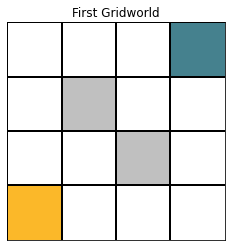

In [ ]:
grid_data = (first_gw.get_grid(), "First Gridworld")
plot_grid_data(grid_data)
plt.show()

In the plot above, the white squares represent walkable squares, which are represented as a 0 in the `numpy` array. 
The grey squares represent terminal states that result in negative reward, which are represented as a -1 in the `numpy` array.
The blue square reprsents a terminal state that results in positive reward, which are represented as a 1 in the `numpy` array.
Finally, the yellow square represents the current state of the agent.

### Example: Random Agent

Now le'ts see our gridworld in action.
In order to interact with any environment we need to come up with a *policy*, a function that maps states to actions.
In this case, we will simply use a policy that chooses actions at random, i.e., the policy returns a random integer from `[0,1,2,3]`. 

In [ ]:
np.random.seed(3)      # don't change this line

num_total_steps = 200   # number of steps taken by the agent

first_gw.reset()        # reset to the initial state

# store initial grid data for animation
grid_data = []     
frame_num = 0
grid_data.append((first_gw.get_grid(), "Frame " + str(frame_num)))    

for i in range(num_total_steps):

    # choose random action
    action = np.random.randint(4)      

    # execute action
    next_state, reward, terminal = first_gw.step(action)       

    # store grid data after executing action
    frame_num += 1
    grid_data.append((first_gw.get_grid(), "Frame " + str(frame_num)))   

    if terminal:    
        first_gw.reset()     # reset if state is terminal

        # store grid data after reseting the environment
        frame_num += 1
        grid_data.append((first_gw.get_grid(), "Frame " + str(frame_num))) 



A straightforward way to tell how our agents are doing is to visualize their behaviour with an animation.
The function below returns a plot of the grid for each given frame. 
We'll use this function along with the function `animation.FuncAnimation` from `matplotlib` to generate the animation.
You don't really need to know how these functions work to complete this assignment, but you can read more about the `FuncAnimation` function [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html).

In [ ]:
def generate_frames(i, grid_data: list, ax):
    """ Generator function that plots the i-th grid in the grid_data array

    param i:            index of the frame to be plotted
    param grid_data:    list of tuples where each tuple contain the grid data
                        in the first entry and the title of the plot in the
                        second entry
    param ax:           subplot axes

    return: a matplotlib AxesImage object
    """

    ax.clear()
    plot = plot_grid_data(grid_data[i], ax=ax)
    return plot

Now let's generate the animation. 
The following cell will take a few seconds to run.

In [ ]:
fig, ax = plt.subplots()
frame_generator = lambda i: generate_frames(i, grid_data, ax=ax)
ani = animation.FuncAnimation(fig, frame_generator, frames=len(grid_data))
plt.close()
ani

As you can see in the animation, it's very difficult for the random agent to reach the terminal state that results in positive reward (the blue square).
Instead, most of the times the agent ends the episode in the bad terminal states (the grey squares).
Try increasing `num_total_steps` to 500 and see if the agent manages to reach the blue square in any of the episodes.
Generating the animation will take a bit longer than last time.

### Assessing Performance

Animations help us visualize how the agent interacts with their environment, but makes it difficult to compare agents to each other. 
To compare the behaviour of two different agents we need to use some kind of quantitative information.
In this case, we can directly use the reward obtained by the agent.
Specifically, we'll measure the average reward per episode.

Let's see how the random agent performs in 200 episodes.
This time we won't be generating an animation since it would take too long.

In [ ]:
num_episodes = 200
current_episode = 0

reward_per_episode = np.zeros(num_episodes, dtype=np.float64)
current_reward_sum = 0

first_gw.reset()     # reset to the initial state


while current_episode < num_episodes:

    # choose random action
    action = np.random.randint(4)                       

    # execute action
    next_state, reward, terminal = first_gw.step(action)         

    # store reward
    current_reward_sum += reward                     

    if terminal:    
        first_gw.reset()
        
        # store sum of rewards for the episode
        reward_per_episode[current_episode] += current_reward_sum
        current_reward_sum = 0

        current_episode += 1

print("The average reward per episode is: ",
      np.round(np.average(reward_per_episode), 2))

The average reward per episode is:  -104.44


Given that the optimal policy would result in a sum of rewards per episode of -4, we can conclude that the random agent is really bad.

## Q-Learning Agent

Now let's implement an agent that actually learns from their environment.
We'll implement the classical algorithm Q-Learning, which approximates the action-value function of the optimal policy.

The Q-Learning agent stores a table of values for each state-action pair. 
Each value is an approximation of the expected sum of discounted rewards that the agent is expected to observe from a given state-action pair. 
On each transition, the agent updates their approximation of the action-value function using the following update rule:

\begin{equation}
    Q(S_t, A_t) ← Q(S_t, A_t) 
    + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) 
    - Q(S_t, A_t)   \right],
\end{equation}

where $S_t$ and $A_t$ are the state and action at time $t$, respectively, $\alpha > 0$ is a learning rate parameter, $\gamma \in [0,1]$ is a discount factor, and $R_{t+1}$ is the reward obtained after executing action $A_t$ at state $S_t$. 
The term inside the square brackets is also known as the TD-error.

**Question 4.1**
Fill in the code in the cell below to implement a Q-Learning agent using the update rule above.

In [ ]:
class QLearningAgent:

    def __init__(self, grid_shape: tuple, num_actions=4,
                 gamma=1.0, learning_rate=0.1):
        """
        param grid_shape:       (tuple) shape of the grid world
        param num_actions:      (int) number of actions available to the agent
        param gamma:            (float or int) discount factor
        param learning_rate:    (float or int) learning rate parameter (alpha)
        """
        self.approx_av = np.zeros(grid_shape + (num_actions,), dtype=np.float64)   # approximate action values
        self.num_actions = num_actions
        self.gamma = gamma
        self.lr = learning_rate
    
    def get_action_values(self, state):
        """
        Returns the approximate action-values of each action for a given state
        """
        return self.approx_av[state[0], state[1], :]

    def update(self, s, a, ns, r):
        """
        Updates the approximate action value for state s and action a
        param s:    state
        param a:    action
        param ns:   next state
        param r:    reward
        """

        ### Your code starts here ###
        # step 1: get action value for (s,a)
        q = self.get_action_values(s)[a]

        # step 2: get max over the action values at the next state
        q_plus_one = np.amax(self.get_action_values(ns))

        # step 3: compute td-error 
        td_error = r + self.gamma * q_plus_one - q                    
    
        # step 4: update approx_av for (s,a)
        self.approx_av[s[0],s[1],a] += self.lr * td_error

But how can we use our Q-Learning agent to generate a policy?
A straightforward way to get a policy is to simply pick the action that maximizes the current approximation of the action value function, also known as the greedy action.
If the approximation is close to the true action values, then the greedy policy should result in a near optimal policy.

Let's implement the greedy policy. 
All you have to do is, given an `numpy` array, return the index of the maximum value in the array.
If there's a tie between two or more values, break the tie at random.

**Question 4.2**
Implement the function `greedy_policy` in the cell below. 
Make sure to break ties uniformly at random. 

In [ ]:
def greedy_policy(action_values: np.ndarray):
    """
    Returns the index of the largest action value in the array
    
    param action_values:    (numpy array) array containing action values
    return: (int) index of the maximum value in the array
    """
    action = None

    ### Your code starts here ###
    action = np.random.choice(np.flatnonzero(action_values == action_values.max()))
   
    ###  Your code ends here  ###
    
    return action

Now let's try the Q-Learning agent with the greedy policy.
We're also going to animate the first 5 and last 5 episodes.

In [ ]:
np.random.seed(42)  # don't change this line

# initiate the agent
learning_rate = 0.1        # default = 0.1, change this value for question 5.3
qlearning_agent = QLearningAgent(grid_shape=first_gw.grid.T.shape,
                                 num_actions=4,
                                 gamma=1.0,
                                 learning_rate=learning_rate)

# for creating animations
grid_data = []
grid_data.append((first_gw.get_grid(), "Episode 1"))
num_plot = 5

# for training and keeping track of learning progress
num_episodes = 200
reward_per_episode = np.zeros(num_episodes, dtype=np.float64)
current_reward_sum = 0
ep_num = 0

# reset environment and start training
first_gw.reset()

while ep_num < num_episodes:

    # get current state, action values, and action
    current_state = first_gw.current_state
    current_avs = qlearning_agent.get_action_values(current_state)
    current_action = greedy_policy(current_avs)

    # environment state
    next_state, reward, terminal = first_gw.step(current_action)

    # store reward info
    current_reward_sum += reward

    # update agent
    qlearning_agent.update(current_state, current_action, next_state, reward)

    # store frame data
    if ep_num < num_plot or ep_num >= num_episodes - num_plot:
        current_gd = (first_gw.get_grid(), "Episode " + str(ep_num + 1))
        grid_data.append(current_gd)
    
    # handle terminal state
    if terminal:
        first_gw.reset()
        
        # store current sum of rewards
        reward_per_episode[ep_num] += current_reward_sum
        current_reward_sum = 0
        ep_num += 1

        # store frame data
        if ep_num < num_plot or ep_num >= num_episodes - num_plot:
            current_gd = (first_gw.get_grid(), "Episode " + str(ep_num + 1))
            grid_data.append(current_gd)
        
print("Average reward per step:", np.round(np.average(reward_per_episode), 2))


Average reward per step: -9.96


This is already a lot better than the random agent.
Let's see the animation.

In [ ]:
fig, ax = plt.subplots()
frame_generator = lambda i: generate_frames(i, grid_data, ax=ax)
ani = animation.FuncAnimation(fig, frame_generator, frames=len(grid_data))
plt.close()
ani

If all went right, you should see that the agent behaves almost randomly in the first 5 episodes.
However, in the last 5 episodes, the agent should already have achieved the optimal policy.

Another way to assess the performance of the agent is by plotting a learning curve. 
A learning curve shows the performance of the agent over time.
If the agent is in fact learning, the learning curve should show the performance improving as the agent interacts with the environment.
In this case, we'll use the reward per episode as the measure of performance.

In [ ]:
def plot_learning_curve(performance: np.ndarray):
    """
    Plots a learning curve

    param performance:  (numpy array) the performance of the agent per episode
    """

    x_axis = np.arange(performance.size) + 1
    plt.plot(x_axis, performance)
    plt.xlabel("Episode Number")
    plt.ylabel("Reward per Episode")
    plt.show()

Now let's see the learning curve. 
Again, if all went well, the agent should have a reward closed to -100 at the begining of training, and a reward of -4 at the end of training.

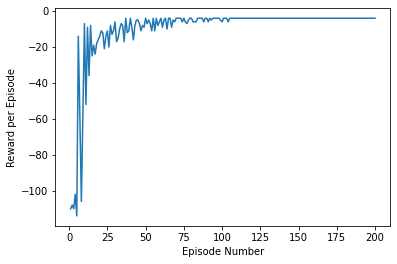

In [ ]:
plot_learning_curve(reward_per_episode)

While this agent performs better than random, it's still possible to do better by tuning the learning rate parameter.

**Question 4.3**
Find a learning rate that achieves a higher average reward per episode than the default learning rate of 0.1. Report the value of the learning rate, its corresponding average reward per episode, and the resulting learning curve.

In [ ]:
np.random.seed(42)  # don't change this line

# initiate the agent
learning_rate = 0.75   # default = 0.1, change this value for question 5.3
qlearning_agent = QLearningAgent(grid_shape=first_gw.grid.T.shape,
                                 num_actions=4,
                                 gamma=1.0,
                                 learning_rate=learning_rate)

# for creating animations
grid_data = []
grid_data.append((first_gw.get_grid(), "Episode 1"))
num_plot = 5

# for training and keeping track of learning progress
num_episodes = 200
reward_per_episode = np.zeros(num_episodes, dtype=np.float64)
current_reward_sum = 0
ep_num = 0

# reset environment and start training
first_gw.reset()

while ep_num < num_episodes:

    # get current state, action values, and action
    current_state = first_gw.current_state
    current_avs = qlearning_agent.get_action_values(current_state)
    current_action = greedy_policy(current_avs)

    # environment state
    next_state, reward, terminal = first_gw.step(current_action)

    # store reward info
    current_reward_sum += reward

    # update agent
    qlearning_agent.update(current_state, current_action, next_state, reward)

    # store frame data
    if ep_num < num_plot or ep_num >= num_episodes - num_plot:
        current_gd = (first_gw.get_grid(), "Episode " + str(ep_num + 1))
        grid_data.append(current_gd)
    
    # handle terminal state
    if terminal:
        first_gw.reset()
        
        # store current sum of rewards
        reward_per_episode[ep_num] += current_reward_sum
        current_reward_sum = 0
        ep_num += 1

        # store frame data
        if ep_num < num_plot or ep_num >= num_episodes - num_plot:
            current_gd = (first_gw.get_grid(), "Episode " + str(ep_num + 1))
            grid_data.append(current_gd)
        
print("Average reward per step:", np.round(np.average(reward_per_episode), 2))


Average reward per step: -7.44


**Answer** - I chose the learning_rate to be 0.75, so Average reward per step equals to -7.44. The learning curve is plotted below:

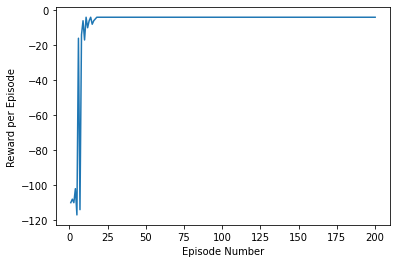

In [ ]:
plot_learning_curve(reward_per_episode)

## A Harder Environment

Now let's try your Q-Learning agent on a harder environment.

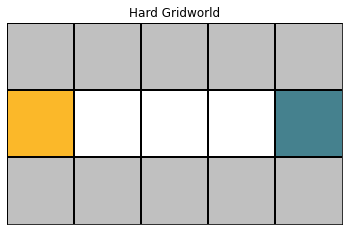

In [ ]:
# define the gridworld as a numpy array
grid = np.array(
    [[-1, -1,  -1,  -1, -1],
     [ 0,  0,   0,   0,  1],
     [-1, -1,  -1,  -1, -1]],
     dtype=np.int64)

# define initial state
starting_state = np.array((0,1))

# define reward function
reward_per_step = -20
terminal_positive_reward = 1000
terminal_negative_reward = 0

# instantiate the gridworld 
hard_gw = GridEnvironment(grid=grid, 
                          start=starting_state, 
                          rps=reward_per_step, 
                          tpr=terminal_positive_reward,
                          tnr=terminal_negative_reward)

# plot the grid
grid_data = (hard_gw.get_grid(), "Hard Gridworld")
plot_grid_data(grid_data)
plt.show()

Initially, this environment seems easier because the agent simply has to walk in a straight line to get a reward of 300.
So how is this environment harder?

Let's try running our Q-Learning agent with the greedy policy in this environment to see if it's really that hard.

In [ ]:
np.random.seed(86)  # don't change this line

# initialize agent
learning_rate = 0.7     # default = 0.1, change this value for Question 5.4
qlearning_agent = QLearningAgent(grid_shape=hard_gw.grid.T.shape,
                                learning_rate=learning_rate)

# for creating animations
grid_data = []
grid_data.append((hard_gw.get_grid(), "Episode 1"))
num_plot = 5

# for training and keeping track of learning progress
num_episodes = 5000
reward_per_episode = np.zeros(num_episodes, dtype=np.float64)
current_reward_sum = 0
ep_num = 0

# reset environment and start learning
hard_gw.reset()

while ep_num < num_episodes:

    # get current state, action values, and action
    current_state = hard_gw.current_state
    current_avs = qlearning_agent.get_action_values(current_state)
    current_action = greedy_policy(current_avs)

    # environment state
    next_state, reward, terminal = hard_gw.step(current_action)

    # store reward info
    current_reward_sum += reward

    # update agent
    qlearning_agent.update(current_state, current_action, next_state, reward)

    # store frame data
    if ep_num < num_plot or ep_num >= num_episodes - num_plot:
        current_gd = (hard_gw.get_grid(), "Episode " + str(ep_num + 1))
        grid_data.append(current_gd)
    
    # handle terminal state
    if terminal:
        hard_gw.reset()

        # store current sum of rewards
        reward_per_episode[ep_num] += current_reward_sum
        current_reward_sum = 0
        ep_num += 1

        # store frame data
        if ep_num < num_plot or ep_num >= num_episodes - num_plot:
            current_gd = (hard_gw.get_grid(), "Episode " + str(ep_num + 1))
            grid_data.append(current_gd)
        
print("Average reward per step:", np.round(np.average(reward_per_episode), 2))

Average reward per step: -20.04


Seems like the agent is achieving an average reward per episode that is less than 0.
However, the optimal policy should get a reward per episode of more than 200.
Let's take a look at the animation.

In [ ]:
fig, ax = plt.subplots()
frame_generator = lambda i: generate_frames(i, grid_data, ax=ax)
ani = animation.FuncAnimation(fig, frame_generator, frames=len(grid_data))
plt.close()
ani

It seems that the agent is not reaching the blue square even after 4,995 episodes of training. 
Perhaps, the problem is that we have chosen a bad value for the learning rate.

**Question 4.4**
Try different values for the learning rate parameter until you find a value that achieves a higher average reward per episode than the default learning rate value.
Report the learning rate and the corresponding average reward per step.
Did the agent reach the blue square?

**Answer** - I chose the learning_rate to be 0.7, so Average reward per step equals to -20.04.
The agent could not make to the blue square.

### The Problem of Exploration

Why is this happening? 
The fundamental problem here is ubiquitous to all of reinforcement learning: *exploration*.
While the final goal of the agent is to maximize the reward they receive, committing too soon to what seems to be an optimal sequence of actions risks never exploring actions that may lead to even higher rewards.
Thus, the agent must continue to explore their environment to guarantee that they will eventually stumble into the optimal sequence of actions.

That's why the agent performs so poorly in this gridworld.
It commits to soon to the sequence of actions that terminates the episode as quickly as possible, not realizing that if they had persevered for a little longer they would gain a high amount of reward.

To solve this problem, we can implement a policy that ocassionally takes a random action with a small probability.
This type of policy is also known as an $\epsilon$-greedy policy because they take a random action with a probability of $\epsilon$ and otherwise they execute the greedy action.

**Question 4.5**
Implement the `epsilon_greedy_policy` in the following cell.

In [ ]:
def epsilon_greedy_policy(action_values: np.ndarray, epsilon=0.1):
    """
    Returns the index of the largest action value in the array
    
    param action_values:    (numpy array) array containing action values
    param epsilon:          (float) probability of choosing an action at random
    return: (int) index of the maximum value in the array
    """
    action = None
    p = np.random.random()
    
    ### Your code starts here ###
    # if p is less than epsilon choose a random action
    if p < epsilon:
      action = np.random.randint(4)
      
    # otherwise, choose the greedy action
    else:
      action = np.random.choice(np.flatnonzero(action_values == action_values.max()))

    ###  Your code ends here  ###
    
    return action

Now, let's see how the Q-Learning agent performs when using an $\epsilon$-greedy policy.
$\epsilon$ is another hyper-parameter that we have to tune.

**Question 4.6**
Find a value of $\epsilon \in [0,1]$ that achieves an average reward per episode greater than 0. 
Report the value of $\epsilon$ and the corresponding average reward per episode.

In [ ]:
np.random.seed(86)  # don't change this line

# hyper-parameters
epsilon = 0.26         # default = 0.0  |  Change this value for Question 5.6
learning_rate = 0.1     # default = 0.1  

# initialize agent
qlearning_agent = QLearningAgent(grid_shape=hard_gw.grid.T.shape,
                                learning_rate=learning_rate)

# for creating animations
grid_data = []
grid_data.append((hard_gw.get_grid(), "Episode 1"))
num_plot = 5

# for training and keeping track of learning progress
num_episodes = 5000
reward_per_episode = np.zeros(num_episodes, dtype=np.float64)
current_reward_sum = 0
ep_num = 0

# reset environment and start training
hard_gw.reset()

while ep_num < num_episodes:

    # get current state, action values, and action
    current_state = hard_gw.current_state
    current_avs = qlearning_agent.get_action_values(current_state)
    current_action = epsilon_greedy_policy(current_avs, epsilon)

    # environment state
    next_state, reward, terminal = hard_gw.step(current_action)

    # store reward info
    current_reward_sum += reward

    # update agent
    qlearning_agent.update(current_state, current_action, next_state, reward)

    # store frame data
    if ep_num < num_plot or ep_num >= num_episodes - num_plot:
        current_gd = (hard_gw.get_grid(), "Episode " + str(ep_num + 1))
        grid_data.append(current_gd)
    
    # handle terminal state
    if terminal:
        hard_gw.reset()

        # store sum of rewards
        reward_per_episode[ep_num] += current_reward_sum
        current_reward_sum = 0
        ep_num += 1

        # store frame data
        if ep_num < num_plot or ep_num >= num_episodes - num_plot:
            current_gd = (hard_gw.get_grid(), "Episode " + str(ep_num + 1))
            grid_data.append(current_gd)
        
print("Average reward per step:", np.round(np.average(reward_per_episode), 2))

Average reward per step: 425.62


**Answer** - I chose the epsilon to be 0.26, so Average reward per step equals to 425.62.



Let's see the animation.

In [ ]:
fig, ax = plt.subplots()
frame_generator = lambda i: generate_frames(i, grid_data, ax=ax)
ani = animation.FuncAnimation(fig, frame_generator, frames=len(grid_data))
plt.close()
ani

If everything went well, the agent should reach the blue square by the end of training this time.

Yes! It does.